In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append(os.path.abspath("../lib"))

In [15]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

In [16]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_dpe.csv", "name": "dpe", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [17]:
dpe = dataframes['dpe'].filter(F.col("heating_emission").cast("int").isNotNull()).withColumn('heating_emission', F.col('heating_emission').cast('int'))
dpe_training = dpe.drop('GES_emission').filter(F.col('DPE_consumption') < 700)
ges_training = dpe.drop('DPE_consumption').filter(F.col('GES_emission') < 200)
dictionary = dataframes['dictionary']

In [18]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import Ridge

# random forest
from sklearn.ensemble import RandomForestRegressor

# XGboost
from xgboost.sklearn import XGBRegressor

# quickXGboost
from sklearn.ensemble import HistGradientBoostingRegressor

#hyperparams
from scipy.stats import uniform, randint

In [19]:
# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

In [20]:
dpe_training_cat = dpe_training.withColumn(
    'DPE_consumption',
    F.when(F.col('DPE_consumption') <= 50, 0)
    .when((F.col('DPE_consumption') > 50) & (F.col('DPE_consumption') <= 90), 1)
    .when((F.col('DPE_consumption') > 90) & (F.col('DPE_consumption') <= 150), 2)
    .when((F.col('DPE_consumption') > 150) & (F.col('DPE_consumption') <= 230), 3)
    .when((F.col('DPE_consumption') > 230) & (F.col('DPE_consumption') <= 330), 4)
    .when((F.col('DPE_consumption') > 330) & (F.col('DPE_consumption') <= 450), 5)
    .otherwise(6)
)

ges_training_cat = ges_training.withColumn(
    'GES_emission',
    F.when(F.col('GES_emission') <= 5, 0)
    .when((F.col('GES_emission') > 5) & (F.col('GES_emission') <= 10), 1)
    .when((F.col('GES_emission') > 10) & (F.col('GES_emission') <= 20), 2)
    .when((F.col('GES_emission') > 20) & (F.col('GES_emission') <= 35), 3)
    .when((F.col('GES_emission') > 35) & (F.col('GES_emission') <= 55), 4)
    .when((F.col('GES_emission') > 55) & (F.col('GES_emission') <= 80), 5)
    .otherwise(6)
)

In [30]:
ges_training_cat.show()
dpe_training_cat.show()
ges_training.show()
dpe_training.show

+----+-----------------+--------------+----------------+------------------+----------------+------------+
|type|construction_date|heating_system|hot_water_system|heating_production|heating_emission|GES_emission|
+----+-----------------+--------------+----------------+------------------+----------------+------------+
|   0|                5|             0|               0|                 1|               3|           3|
|   0|                2|             0|               0|                 3|               3|           1|
|   1|                3|             1|               1|                 4|               3|           2|
|   1|                1|             1|               1|                 1|               3|           5|
|   1|                2|             1|               0|                 4|               3|           5|
|   1|                2|             1|               0|                 4|               3|           3|
|   1|                1|             0|       

(array([0, 1, 2, 3, 4, 5, 6]), array([12235, 25189, 16484, 17578, 15420,  8767,  4327], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 3310, 17104, 35671, 24751, 13759,  4292,  1113], dtype=int64))


(array([ 9071., 41898., 24592., 13647.,  6432.,  2720.,   970.,   397.,
          189.,    84.]),
 array([1.0000e-01, 6.9850e+01, 1.3960e+02, 2.0935e+02, 2.7910e+02,
        3.4885e+02, 4.1860e+02, 4.8835e+02, 5.5810e+02, 6.2785e+02,
        6.9760e+02]),
 <BarContainer object of 10 artists>)

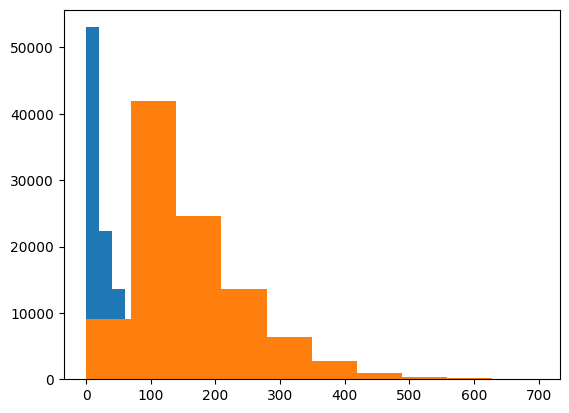

In [36]:
print(np.unique(y_ges_cat, return_counts=True))
print(np.unique(y_dpe_cat, return_counts=True))
plt.hist(y_ges_reg)
plt.hist(y_dpe_reg)


In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from show import show_matrix, show_result

In [22]:
categorical_features = [i for i in range(6)]

dpe_param_reg = {'l2_regularization': 0.9632366534401319, 'learning_rate': 0.039390694124254874, 'max_iter': 120, 'categorical_features' : categorical_features}
ges_param_reg = {'l2_regularization': 0.11976213181925122, 'learning_rate': 0.2971581842219685, 'max_iter': 124,'categorical_features' : categorical_features}

ges_param_cat = {'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 103}
dpe_param_cat = {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 108}

col_X_hot = []
col_y_ges = ['GES_emission']
col_y_dpe = ['DPE_consumption']

col_X_not_hot = [col[0] for col in ges_training.dtypes if col[0] not in col_X_hot + col_y_ges]

X = dpe_training.select(col_X_not_hot).toPandas().to_numpy()

y_ges_cat = ges_training_cat.select(col_y_ges).toPandas().to_numpy().ravel()
y_dpe_cat = dpe_training_cat.select(col_y_dpe).toPandas().to_numpy().ravel()
if 0 not in np.unique(y_ges_cat):
    y_ges_cat = y_ges_cat - 1
if 0 not in np.unique(y_dpe_cat):
    y_dpe_cat = y_dpe_cat - 1

y_ges_reg = ges_training.select(col_y_ges).toPandas().to_numpy().ravel()
y_dpe_reg = dpe_training.select(col_y_dpe).toPandas().to_numpy().ravel()

treshold = 100000
if X.shape[0] > treshold:
    np.random.seed(42)
    indexes = np.random.choice(X.shape[0], treshold, replace=False)
    X = X[indexes, :]
    y_ges_cat = y_ges_cat[indexes]
    y_dpe_cat = y_dpe_cat[indexes]
    y_ges_reg = y_ges_reg[indexes]
    y_dpe_reg = y_dpe_reg[indexes]

poly = PolynomialFeatures(1)
X = StandardScaler().fit_transform(X)
X = poly.fit_transform(X)

In [23]:
ges_regressor = HistGradientBoostingRegressor(**ges_param_reg)
dpe_regressor = HistGradientBoostingRegressor(**dpe_param_reg)
ges_classifier = RandomForestClassifier(**ges_param_cat)
dpe_classifier = RandomForestClassifier(**dpe_param_cat)

y_pred_ges_regressor = cross_val_predict(ges_regressor, X, y_ges_reg, cv=4)
y_pred_dpe_regressor = cross_val_predict(dpe_regressor, X, y_dpe_reg, cv=4)
y_pred_ges_classifier = cross_val_predict(ges_classifier, X, y_ges_cat, cv=4)
y_pred_dpe_classifier = cross_val_predict(dpe_classifier, X, y_dpe_cat, cv=4)



In [24]:
y_pred_ges_regressor_to_cat = (
    spark.createDataFrame(y_pred_ges_regressor, ['GES_emission'])
    .withColumn(
        'GES_emission',
        F.when(F.col('GES_emission') <= 5, 0)
        .when((F.col('GES_emission') > 5) & (F.col('GES_emission') <= 10), 1)
        .when((F.col('GES_emission') > 10) & (F.col('GES_emission') <= 20), 2)
        .when((F.col('GES_emission') > 20) & (F.col('GES_emission') <= 35), 3)
        .when((F.col('GES_emission') > 35) & (F.col('GES_emission') <= 55), 4)
        .when((F.col('GES_emission') > 55) & (F.col('GES_emission') <= 80), 5)
        .otherwise(6)
    )
    .toPandas()
    .to_numpy()
    .ravel()
)

y_pred_dpe_regressor_to_cat = (
    spark.createDataFrame(y_pred_dpe_regressor, ['DPE_consumption'])
    .withColumn(
        'DPE_consumption',
        F.when(F.col('DPE_consumption') <= 50, 0)
        .when((F.col('DPE_consumption') > 50) & (F.col('DPE_consumption') <= 90), 1)
        .when((F.col('DPE_consumption') > 90) & (F.col('DPE_consumption') <= 150), 2)
        .when((F.col('DPE_consumption') > 150) & (F.col('DPE_consumption') <= 230), 3)
        .when((F.col('DPE_consumption') > 230) & (F.col('DPE_consumption') <= 330), 4)
        .when((F.col('DPE_consumption') > 330) & (F.col('DPE_consumption') <= 450), 5)
        .otherwise(6)
    )
    .toPandas()
    .to_numpy()
    .ravel()
)

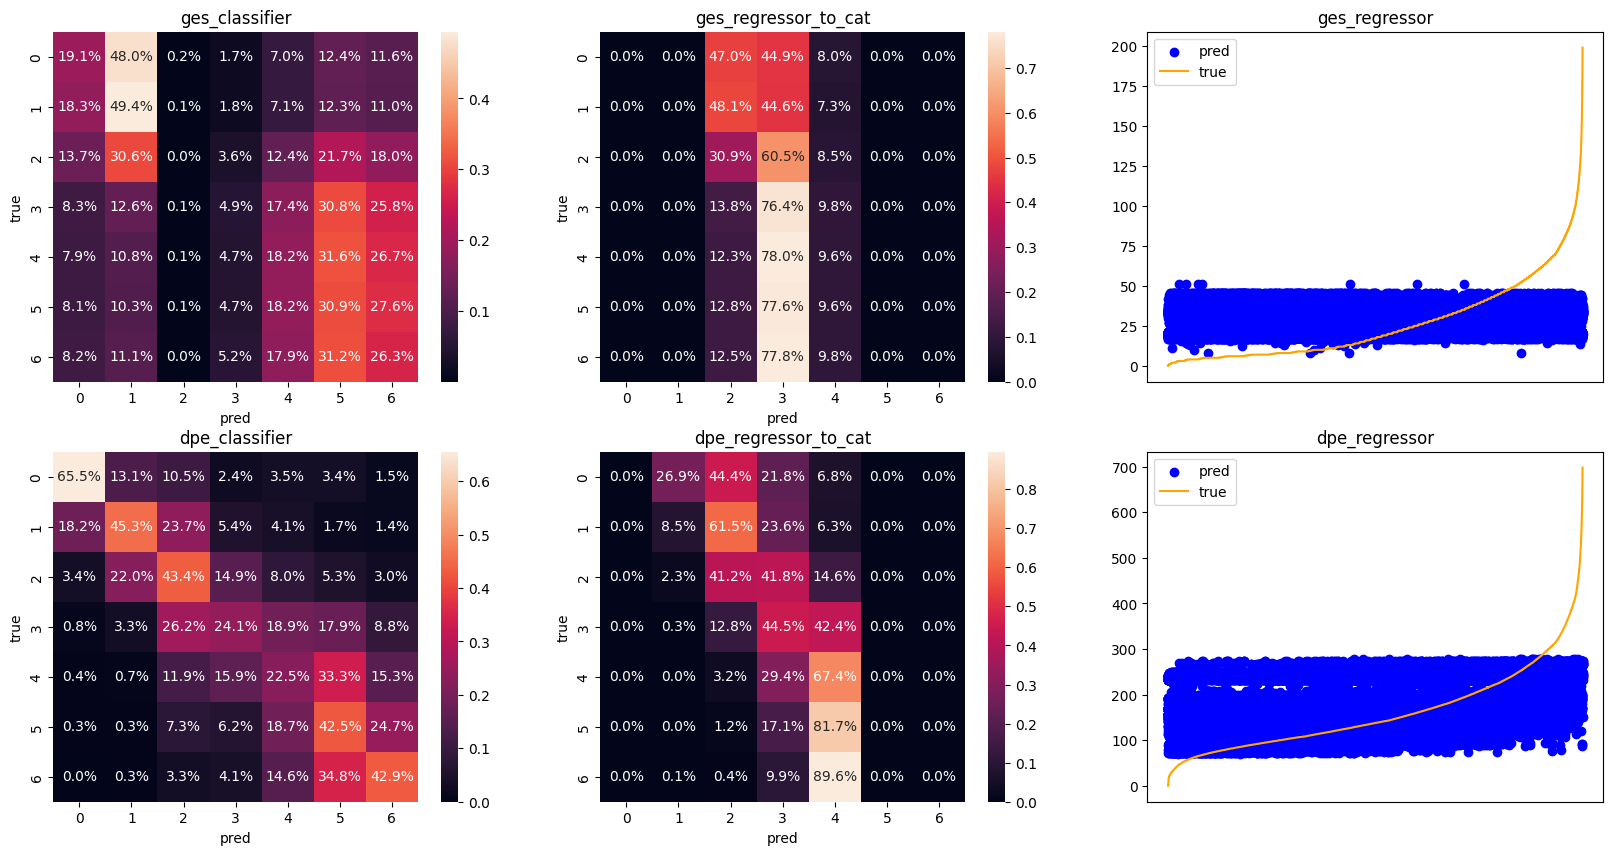

In [25]:
f, ax = plt.subplots(2,3, figsize=(20,10))
show_matrix(y_pred_ges_classifier, y_ges_cat, ax[0,0], 'ges_classifier')
show_matrix(y_pred_ges_regressor_to_cat, y_ges_cat, ax[0,1], 'ges_regressor_to_cat')
show_result(y_pred_ges_regressor, y_ges_reg, ax[0,2], 'ges_regressor')

show_matrix(y_pred_dpe_classifier, y_dpe_cat, ax[1,0], 'dpe_classifier')
show_matrix(y_pred_dpe_regressor_to_cat, y_dpe_cat, ax[1,1], 'dpe_regressor_to_cat')
show_result(y_pred_dpe_regressor, y_dpe_reg, ax[1,2], 'dpe_regressor')
plt.show()